<center>
<img src="https://www.seekpng.com/png/full/113-1133172_digital-marketing-digital-marketing-clipart.png" width=600>
</center>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">E-commerce Journey Prediction</div>

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Read the data and Feature enginnering](#explore_clean_format)
2. [Classifier to Detect Segments](#eda_to_understand_data)
3. [Markov Chain Model for future prediction](#feture_engineering_and_rfm)
4. [LSTM to predict future segments](#kmeans_segments)

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import re
from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pickle 

sns.set_context("talk")
sns.despine()
sns.set_style("darkgrid")
pd.set_option('display.max_rows', 500)

<Figure size 640x480 with 0 Axes>

<h1 align="left"><font color='green'>1. Read the data and Feature enginnering </font></h1> <a class='anchor' id='explore_clean_format'></a>

In [2]:
# Read the data from a parquet file
df = pd.read_parquet('OnlineRetail.parquet')
# Filter out the outliers in UnitPrice and Quantity columns
df = df[(df['UnitPrice']<6000) & (df['Quantity']<6000)]
# Read the features dataset from a csv file
features_dataset = pd.read_csv("FeaturesDataset.csv")
# Calculate the amount by multiplying Quantity and UnitPrice
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [3]:
# Define the current date as 31st December 2011
current_date = datetime(2011,12,31)
# Group the data by CustomerID and InvoiceNo and calculate the sum of Amount, the count of StockCode and the first InvoiceDate for each group
df = df.groupby(['CustomerID','InvoiceNo']).agg({"Amount":"sum","StockCode":"count","InvoiceDate":"first"}).reset_index()
# Rename the columns to more meaningful names
df = df.rename(columns = {"Amount":"AmountSpent","StockCode":"ItemsPurchased","InvoiceDate":"DateOfPurchase"})

In [4]:
# Calculate the cumulative amount spent by each customer by sorting the data by DateOfPurchase and applying the cumsum method on AmountSpent column
df['cumamount'] = df.sort_values(by = ['DateOfPurchase'], ascending=True).groupby('CustomerID')['AmountSpent'].cumsum() 
# Calculate the cumulative number of items purchased by each customer by sorting the data by DateOfPurchase and applying the cumsum method on ItemsPurchased column
df['cumorders'] = df.sort_values(by = ['DateOfPurchase'], ascending=True).groupby('CustomerID')['ItemsPurchased'].cumsum() 
# Calculate the recency of each purchase by subtracting the DateOfPurchase from the current date and converting it to days
df['Recency'] = df['DateOfPurchase'].apply(lambda x : (current_date - x).days)

In [5]:
# Select only the columns of interest: CustomerID, cumamount, cumorders and Recency
df = df[['CustomerID','cumamount','cumorders','Recency']]
# Rename the columns to more meaningful names: Monetary and Frequency
df = df.rename(columns = {'cumamount':'Monetary','cumorders':'Frequency'})

In [6]:
df

,CustomerID,Monetary,Frequency,Recency
0,12347.0,711.79,31,388
1,12347.0,1187.18,60,338
2,12347.0,1823.43,84,267
3,12347.0,2205.95,102,204
4,12347.0,2790.86,124,150
...,...,...,...,...
18524,18283.0,1886.88,706,30
18525,18283.0,2094.88,756,24
18526,18287.0,765.28,29,222
18527,18287.0,1766.60,67,79


<h1 align="left"><font color='green'>2. Classifier to Detect customer segments</font></h1> <a class='anchor' id='eda_to_understand_data'></a>

In [7]:
# Select the features and the target variable from the features dataset
data_to_train = features_dataset[['URecency','UMonetary','UFrequency','Segments']]
# Create a random forest classifier with a fixed random state
rf = RandomForestClassifier(random_state=42) 
# Split the data into training and testing sets with a 33% test size and a fixed random state
X_train, X_test, y_train, y_test = train_test_split(data_to_train.drop(columns = "Segments"), data_to_train[['Segments']].values.ravel(), test_size=0.33, random_state=42)
# Train the random forest classifier on the training data
rf.fit(X_train,y_train)
# Predict the target variable on the testing data
ypred = rf.predict(X_test)

In [8]:
# from the report we observe the classifier perfectly classifies the segments 
print(classification_report(y_test,ypred))

                     precision    recall  f1-score   support

     about_to_sleep       0.99      0.99      0.99        91
            at_Risk       0.98      0.98      0.98       198
         cant_loose       1.00      0.96      0.98        27
          champions       1.00      1.00      1.00       206
        hibernating       0.99      0.99      0.99       329
    loyal_customers       1.00      1.00      1.00       276
     need_attention       0.98      0.97      0.98        66
      new_customers       1.00      1.00      1.00        18
potential_loyalists       0.99      1.00      1.00       188
          promising       1.00      0.97      0.98        33

           accuracy                           0.99      1432
          macro avg       0.99      0.99      0.99      1432
       weighted avg       0.99      0.99      0.99      1432



In [9]:
# Create a final random forest classifier with a fixed random state
rf_final = RandomForestClassifier(random_state=42)
# Train the final random forest classifier on the entire data
rf_final.fit(data_to_train.drop(columns = "Segments"), data_to_train[['Segments']].values.ravel())


# Predict the segments for each customer using the final random forest classifier and the Recency, Monetary and Frequency columns
# Rename the columns to match the features used for training the classifier
df['Path'] = rf_final.predict(df[['Recency','Monetary','Frequency']].rename(columns = {'Recency':"URecency",'Monetary':"UMonetary","Frequency":"UFrequency"}))

#### Potential Paths Took By Some Random Customers

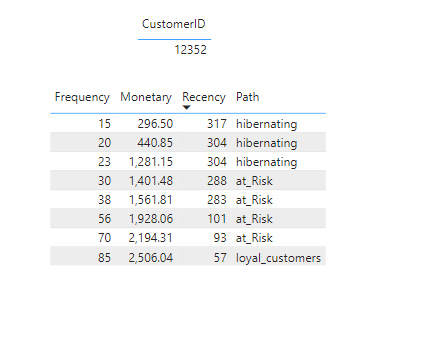


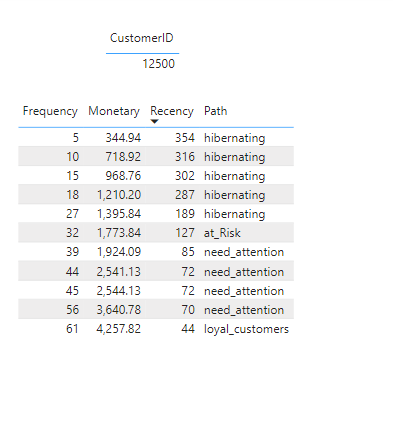


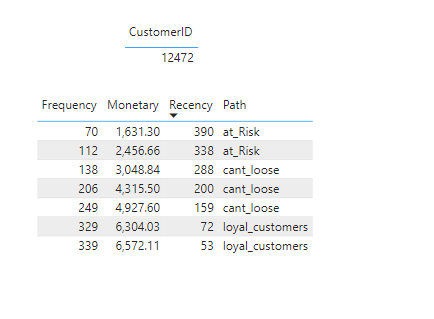

<h1 align="left"><font color='green'>3.Create Markov Chain model </font></h1> <a class='anchor' id='feture_engineering_and_rfm'></a>

1. A Markov chain is a type of stochastic model that describes a sequence of possible events in which the probability of each event depends only on the state attained in the previous event1. This means that the future behavior of the system is independent of its past history and only depends on its current state. This property is also called memorylessness
2. We will use markov chain to predict next stage of customer journey using probablity transition matrix

In [10]:
def remove_duplicates_preserve_order(lst):
    unique_list = []
    unique_set = set()
    for item in lst:
        if item not in unique_set:
            unique_list.append(item)
            unique_set.add(item)
    return unique_list


In [11]:
# Group the data by CustomerID and create a list of segments for each customer
potential_paths = df.dropna().groupby("CustomerID")['Path'].apply(list)
# Remove any duplicate segments from each list and preserve the order
potential_paths = potential_paths.apply(remove_duplicates_preserve_order)
# Filter out the customers who have only one segment in their list
potential_paths = potential_paths[potential_paths.apply(lambda x : False if len(x) == 1 else True)]
# Convert the series of lists to a list of lists
potential_paths = potential_paths.values.tolist()

In [12]:
# Create an empty set to store the unique states
states = set()
# Loop through each potential path
for path in potential_paths: 
    # Loop through each state in the path
    for state in path: 
        # Add the state to the set if it is not already there
        states.add(state)
        
# Convert the set to a list
states = list(states)

# Get the number of states
n_states = len(states)
# Create a zero matrix of size n_states by n_states
transition_matrix = np.zeros((n_states, n_states))

In [13]:
# Loop through each potential path
for path in potential_paths: 
    # Loop through each pair of consecutive states in the path
    for i in range(len(path) - 1): 
        # Get the index of the current state in the states list
        current_state = states.index(path[i])
        # Get the index of the next state in the states list
        next_state = states.index(path[i+1])
        # Increment the corresponding entry in the transition matrix by 1
        transition_matrix[current_state, next_state] += 1 
# Divide each row of the transition matrix by its sum to get the probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis = 1, keepdims = True)

C:\Users\siddharth_black_pred\AppData\Local\Temp\ipykernel_13060\26198696.py:12: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis = 1, keepdims = True)


In [14]:
transition = pd.DataFrame(transition_matrix, columns=states)
transition.index = states 
transition

,new_customers,champions,potential_loyalists,promising,at_Risk,hibernating,loyal_customers,need_attention,cant_loose,about_to_sleep
new_customers,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
champions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
potential_loyalists,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000
promising,0.526316,0.000000,0.473684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
at_Risk,0.000000,0.052902,0.039677,0.000000,0.000000,0.002204,0.437913,0.082292,0.385011,0.000000
hibernating,0.010969,0.001828,0.102986,0.015235,0.659354,0.000000,0.021938,0.091408,0.002438,0.093845
loyal_customers,0.000000,0.993562,0.000000,0.002146,0.000000,0.000000,0.000000,0.004292,0.000000,0.000000
need_attention,0.000000,0.116667,0.433333,0.000000,0.000000,0.000000,0.444444,0.000000,0.000000,0.005556
cant_loose,0.000000,0.051502,0.000000,0.000000,0.000000,0.000000,0.948498,0.000000,0.000000,0.000000
about_to_sleep,0.035211,0.007042,0.612676,0.112676,0.000000,0.000000,0.056338,0.176056,0.000000,0.000000


In [15]:
# Predict the text path 

In [16]:
current_path = ['hibernating', 'at_Risk', 'loyal_customers'] 
current_state_index = states.index(current_path[-1])
next_state_index = np.random.choice(n_states, p = transition_matrix[current_state_index])
next_state = states[next_state_index] 
print(f"{current_path} >>> {next_state}")

['hibernating', 'at_Risk', 'loyal_customers'] >>> champions


<h1 align="left"><font color='green'>4. LSTM for future prediction</font></h1> <a class='anchor' id='kmeans_segments'></a>

Problem With Markov Chain: It may not be realistic to assume that the future state only depends on the current state and not on the past history. to overcome this we are using LSTM


LSTM stands for Long Short-Term Memory, which is a type of recurrent neural network (RNN) that can process sequential data and learn long-term dependencies12. Unlike standard RNNs, LSTM has a special memory cell that can store and update information over arbitrary time intervals. The memory cell is regulated by three gates: an input gate, a forget gate, and an output gate. The input gate decides which new information to store in the cell, the forget gate decides which old information to discard from the cell, and the output gate decides which information to output from the cell

The advantage of LSTM over Markov chains are: 

LSTM can capture long-term dependencies and complex patterns in sequential data, while Markov chain assumes that the future state only depends on the current state and not on the past history12.

In [1]:
import pandas as pd 
import numpy as np 
import pickle
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 

In [2]:
corpus = pickle.load(open("potential_paths.pickle","rb"))
corpus = [" ".join(c) for c in corpus]

In [3]:
# create a tokenizer object that removes punctuation and other symbols
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',oov_token="<oov>") 

# fit the tokenizer on the corpus of text
tokenizer.fit_on_texts(corpus)

# get the dictionary of word to index mappings
tokenizer.word_index

{'<oov>': 1,
 'hibernating': 2,
 'at_risk': 3,
 'loyal_customers': 4,
 'champions': 5,
 'cant_loose': 6,
 'potential_loyalists': 7,
 'need_attention': 8,
 'about_to_sleep': 9,
 'promising': 10,
 'new_customers': 11}

In [4]:
# convert the text corpus into sequences of indices using the tokenizer
sequences = tokenizer.texts_to_sequences(corpus)

# find the maximum length of any sequence in the corpus
max_sequence_length = max([len(seq) for seq in sequences]) 

# pad the sequences with zeros to make them all have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length,padding='pre')

In [5]:
# split the padded sequences into inputs and targets for training
# the inputs are all the words except the last one in each sequence
# the targets are the last words in each sequence
train_inputs = padded_sequences[:,:-1] 
train_targets = padded_sequences[:,-1]

# get the size of the vocabulary from the tokenizer
vocabulary_size = len(tokenizer.word_counts)+1

In [8]:
# create a sequential model
model = Sequential() 

# add an embedding layer that maps each word index to a 16-dimensional vector
model.add(Embedding(vocabulary_size+1, 16, input_length = max_sequence_length-1)) 

# add a LSTM layer that learns the sequential patterns in the inputs
model.add(LSTM(50)) 
model.add(Dense(32, activation = "relu"))
# add a dense layer that outputs a probability distribution over the vocabulary
model.add(Dense(vocabulary_size+1, activation = "softmax"))

# compile the model with a loss function, an optimizer and a metric
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model on the inputs and targets for 30 epochs
model.fit(train_inputs,train_targets,epochs=50,verbose=1, validation_split = 0.2, shuffle = True)


Epoch 1/50
60/60 [==============================] - 2s 9ms/step - loss: 2.1862 - accuracy: 0.3211 - val_loss: 1.8963 - val_accuracy: 0.4021
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 1.7461 - accuracy: 0.4621 - val_loss: 1.6950 - val_accuracy: 0.4758
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 1.4773 - accuracy: 0.5221 - val_loss: 1.4272 - val_accuracy: 0.4737
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 1.2613 - accuracy: 0.5811 - val_loss: 1.2464 - val_accuracy: 0.5705
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 1.1203 - accuracy: 0.6258 - val_loss: 1.1466 - val_accuracy: 0.6253
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 1.0545 - accuracy: 0.6526 - val_loss: 1.1222 - val_accuracy: 0.6337
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 1.0237 - accuracy: 0.6674 - val_loss: 1.1008 - val_accuracy: 0.6337
Epoch 8/50
60/60 [==

<AxesSubplot:>

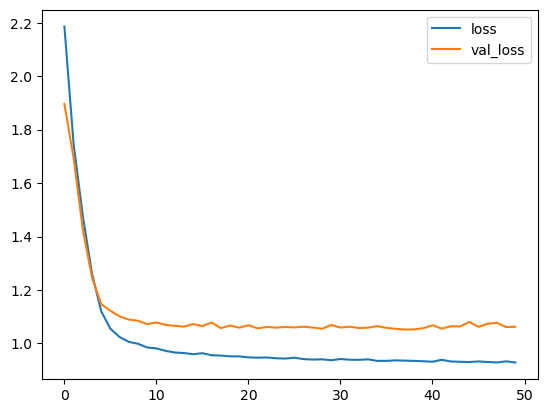

In [15]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [16]:
# define a function that predicts the next word(s) given a seed text
def predict_next_state(seed_text, next_words = 1):
    # uncomment the following line to use the first sentence in the corpus as the seed text
    #seed_text = " ".join(corpus[0].split(" ")[:-1])
    
    # loop for the number of words to predict
    for _ in range(next_words): 
        # convert the seed text into a sequence of indices using the tokenizer
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # pad the sequence with zeros to match the input length of the model
        token_list = pad_sequences([token_list], maxlen = max_sequence_length - 1, padding = "pre") 
        
        # use the model to predict the next word index given the sequence
        predicted = np.argmax(model.predict(token_list), axis = 1) 
        
        # initialize an empty string to store the output word
        output_word = "" 
        
        # loop through the word index dictionary to find the word that matches the predicted index
        for word, index in tokenizer.word_index.items(): 
            if index == predicted: 
                output_word = word 
                break 
        
        # append the output word to the seed text with a separator
        seed_text += " >>> " + output_word
    
    # print the final seed text with the predicted words
    return seed_text

In [17]:
predict_next_state("at_Risk cant_loose loyal_customers")

1/1 [==============================] - 0s 19ms/step


'at_Risk cant_loose loyal_customers >>> champions'

In [18]:
predict_next_state("hibernating need_attention")

1/1 [==============================] - 0s 18ms/step


'hibernating need_attention >>> potential_loyalists'